In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
import seaborn as sns
import sys
import os
import math
import time
import random
import warnings
warnings.filterwarnings("ignore")

## 5. Ratings
Consisting of 26 million ratings and 750,000 tag applications from 270,000 users on all the 45,000 movies in this dataset

In [2]:
ratings = pd.read_csv('../data/ratings.csv')
print('ratings.shape', ratings.shape)
ratings.head()

ratings.shape (26024289, 4)


,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [3]:
movies = pd.read_csv('../data/movies_w_description.csv')
print('movies.shape', movies.shape)
movies.head()

movies.shape (41999, 5)


,movieId,overview,genres,title,keywords
0,1,"Led by Woody, Andy's toys live happily in his ...","['Animation', 'Comedy', 'Family']",Toy Story,"['jealousy', 'toy', 'boy', 'friendship', 'frie..."
1,2,When siblings Judy and Peter discover an encha...,"['Adventure', 'Fantasy', 'Family']",Jumanji,"['board game', 'disappearance', ""based on chil..."
2,3,A family wedding reignites the ancient feud be...,"['Romance', 'Comedy']",Grumpier Old Men,"['fishing', 'best friend', 'duringcreditssting..."
3,4,"Cheated on, mistreated and stepped on, the wom...","['Comedy', 'Drama', 'Romance']",Waiting to Exhale,"['based on novel', 'interracial relationship',..."
4,5,Just when George Banks has recovered from his ...,['Comedy'],Father of the Bride Part II,"['baby', 'midlife crisis', 'confidence', 'agin..."


In [4]:
ratings = ratings[ratings['movieId'].isin(movies['movieId'])]
ratings.shape

(25941199, 4)

In [5]:
DATA_DIR = 'data/processed'
POSITIVE_RATING_THRESHOLD = 4
MIN_USER_COUNT = 5  # only keep the user who gives at least min_user_count ratings
MIN_MOVIE_COUNT = 5  # only keep the movie that receives at least min_movie_count ratings
SORTED_BY_TIMESTAMP = False  # sort the ratings by timestamp before split tr and te
NUM_USER_TEST = 12000
SEED = 98765

In [6]:
# binarize the data (only keep ratings >= 4)
ratings = ratings[ratings['rating'] >= POSITIVE_RATING_THRESHOLD]
print('ratings.shape', ratings.shape)
ratings.head()

ratings.shape (12937988, 4)


,userId,movieId,rating,timestamp
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
5,1,1968,4.0,1425942148


In [7]:
n_user = len(ratings['userId'].unique())
n_movie = len(ratings['movieId'].unique())

sparsity = 1. * ratings.shape[0] / (n_user * n_movie)

print("Before filtering, there are %d ratings from %d users and %d movies (sparsity: %.3f%%)" % 
      (ratings.shape[0], n_user, n_movie, sparsity * 100))

Before filtering, there are 12937988 ratings from 265039 users and 30222 movies (sparsity: 0.162%)


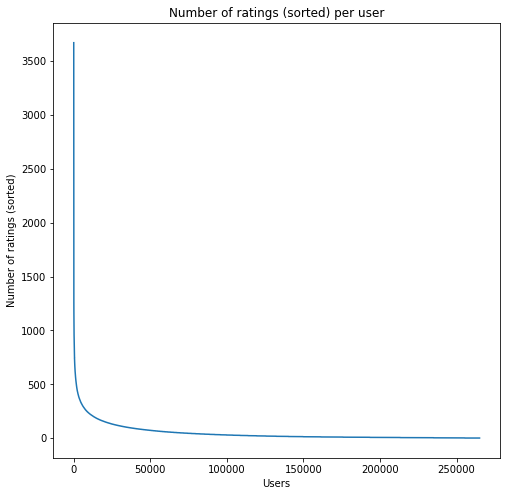

In [8]:
sorted_ratings_per_user = np.sort(ratings.groupby('userId').count()['rating'])[::-1]

plt.figure(figsize=(8,8))
plt.plot(sorted_ratings_per_user)
plt.ylabel("Number of ratings (sorted)")
plt.xlabel("Users")
plt.title('Number of ratings (sorted) per user');

In [9]:
sorted_ratings_per_user.mean(), sorted_ratings_per_user.max()

(48.815412071431, 3672)

In [12]:
np.quantile(sorted_ratings_per_user, [0.5, 0.75])

array([17., 52.])

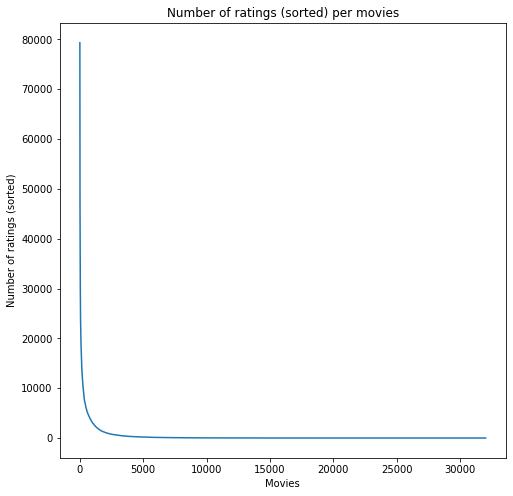

In [7]:
sorted_ratings_per_movie = np.sort(ratings.groupby('movieId').count()['rating'])[::-1]

plt.figure(figsize=(8,8))
plt.plot(sorted_ratings_per_movie)
plt.ylabel("Number of ratings (sorted)")
plt.xlabel("Movies")
plt.title('Number of ratings (sorted) per movies');

In [8]:
def get_count(data, id):
    playcount_groupbyid = data[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count

In [9]:
def filter_triplets(data, min_user_count=0, min_movie_count=0):
    """
        min_user_count: only keep the user who gives at least min_user_count ratings
        min_movie_count: only keep the movie that receives at least min_movie_count ratings
    """
    # Only keep the data for items which were clicked on by at least min_sc users. 
    if min_movie_count > 0:
        itemcount = get_count(data, 'movieId')
        data = data[data['movieId'].isin(itemcount[itemcount['size'] >= min_movie_count]['movieId'])]
    
    # Only keep the triplets for users who clicked on at least min_uc items
    # After doing this, some of the items will have less than min_uc users, but should only be a small proportion
    if min_user_count > 0:
        usercount = get_count(data, 'userId')
        data = data[data['userId'].isin(usercount[usercount['size'] >= min_user_count]['userId'])]
    
    # Update both usercount and itemcount after filtering
    usercount, itemcount = get_count(data, 'userId'), get_count(data, 'movieId') 
    return data, usercount, itemcount

In [10]:
ratings, user_activity, movie_popularity = filter_triplets(ratings, MIN_USER_COUNT, MIN_MOVIE_COUNT)

In [11]:
sparsity = 1. * ratings.shape[0] / (user_activity.shape[0] * movie_popularity.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (ratings.shape[0], user_activity.shape[0], movie_popularity.shape[0], sparsity * 100))

After filtering, there are 12851343 watching events from 224089 users and 17888 movies (sparsity: 0.321%)


In [16]:
sparsity = 1. * ratings.shape[0] / (user_activity.shape[0] * movie_popularity.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (ratings.shape[0], user_activity.shape[0], movie_popularity.shape[0], sparsity * 100))

After filtering, there are 12877023 watching events from 224147 users and 31985 movies (sparsity: 0.180%)


In [17]:
unique_uid = user_activity['userId'].to_numpy()
n_users = len(unique_uid)

np.random.seed(SEED)
idx_perm = np.random.permutation(n_users)
unique_uid = unique_uid[idx_perm]

In [18]:
# create train/validation/test users

tr_users = unique_uid[:(n_users - NUM_USER_TEST * 2)]
vd_users = unique_uid[(n_users - NUM_USER_TEST * 2): (n_users - NUM_USER_TEST)]
te_users = unique_uid[(n_users - NUM_USER_TEST):]

In [19]:
len(tr_users), len(vd_users), len(te_users)

(200147, 12000, 12000)

In [20]:
train_ratings = ratings.loc[ratings['userId'].isin(tr_users)]

In [21]:
len(train_ratings['userId'].unique())

200147

In [22]:
unique_sid = pd.unique(train_ratings['movieId'])
len(unique_sid)

30920

In [23]:
movieId2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
userId2id = dict((pid, i) for (i, pid) in enumerate(unique_uid))

In [24]:
NAME_DIR = '{}_{}_{}_{}_{}_{}'.format(POSITIVE_RATING_THRESHOLD, MIN_USER_COUNT, MIN_MOVIE_COUNT,SORTED_BY_TIMESTAMP,NUM_USER_TEST,SEED)
processed_data_dir = os.path.join(DATA_DIR, NAME_DIR)
processed_data_dir

'data/processed/4_5_0_False_12000_98765'

In [25]:
if not os.path.exists(processed_data_dir):
    os.makedirs(processed_data_dir)

with open(os.path.join(processed_data_dir, 'unique_sid.txt'), 'w') as f:
    for sid in unique_sid:
        f.write('%s\n' % sid)

In [26]:
def split_train_test_proportion(data, sorted_by_timestamp, test_prop=0.2):
    data_grouped_by_user = data.groupby('userId')
    tr_list, te_list = list(), list()

    for i, (_, group) in enumerate(data_grouped_by_user):
        n_items_u = len(group)
        if n_items_u < 2:
            continue
        if sorted_by_timestamp:
            group = group.sort_values('timestamp')


        idx = np.zeros(n_items_u, dtype='bool')
        test_size = max(1, int(test_prop * n_items_u))
        
        if sorted_by_timestamp:
            idx[-test_size:] = True
        else:
            idx[np.random.choice(n_items_u, size=test_size, replace=False).astype('int64')] = True

        tr_list.append(group[np.logical_not(idx)])
        te_list.append(group[idx])


        if i % 1000 == 0:
            print("%d users sampled" % i)
            sys.stdout.flush()

    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    
    return data_tr, data_te

In [27]:
vad_ratings = ratings.loc[ratings['userId'].isin(vd_users)]
vad_ratings = vad_ratings.loc[vad_ratings['movieId'].isin(unique_sid)]

In [28]:
len(vad_ratings['userId'].unique())

12000

In [29]:
vad_ratings_tr, vad_ratings_te = split_train_test_proportion(vad_ratings, SORTED_BY_TIMESTAMP, test_prop=0.2)

vad_ratings_tr.shape, vad_ratings_te.shape

0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled
10000 users sampled
11000 users sampled


((547074, 4), (131071, 4))

In [30]:
len(vad_ratings_tr['userId'].unique()), len(vad_ratings_te['userId'].unique())

(12000, 12000)

In [31]:
test_ratings = ratings.loc[ratings['userId'].isin(te_users)]
test_ratings = test_ratings.loc[test_ratings['movieId'].isin(unique_sid)]

In [32]:
test_ratings_tr, test_ratings_te = split_train_test_proportion(test_ratings, SORTED_BY_TIMESTAMP, test_prop=0.2)

test_ratings_tr.shape, test_ratings_te.shape

0 users sampled
1000 users sampled
2000 users sampled
3000 users sampled
4000 users sampled
5000 users sampled
6000 users sampled
7000 users sampled
8000 users sampled
9000 users sampled
10000 users sampled
11000 users sampled


((548964, 4), (131544, 4))

In [33]:
len(test_ratings_tr['userId'].unique()), len(test_ratings_te['userId'].unique())

(11999, 11999)

In [34]:
def numerize(data, userId2id, movieId2id):
    uid = data['userId'].apply(lambda x: userId2id[x])
    sid = data['movieId'].apply(lambda x: movieId2id[x])
    return pd.DataFrame(data={'uid': uid, 'sid': sid}, columns=['uid', 'sid'])

In [35]:
train_data = numerize(train_ratings, userId2id, movieId2id)
train_data.to_csv(os.path.join(processed_data_dir, 'train.csv'), index=False)

In [36]:
vad_data_tr = numerize(vad_ratings_tr, userId2id, movieId2id)
vad_data_tr.to_csv(os.path.join(processed_data_dir, 'validation_tr.csv'), index=False)

In [37]:
vad_data_te = numerize(vad_ratings_te, userId2id, movieId2id)
vad_data_te.to_csv(os.path.join(processed_data_dir, 'validation_te.csv'), index=False)

In [38]:
test_data_tr = numerize(test_ratings_tr, userId2id, movieId2id)
test_data_tr.to_csv(os.path.join(processed_data_dir, 'test_tr.csv'), index=False)

In [39]:
test_data_te = numerize(test_ratings_te, userId2id, movieId2id)
test_data_te.to_csv(os.path.join(processed_data_dir, 'test_te.csv'), index=False)

In [40]:
processed_data_dir

'data/processed/4_5_0_False_12000_98765'

In [41]:
unique_sid = list()
with open(os.path.join(processed_data_dir, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

n_items = len(unique_sid)
n_items

30920

In [42]:
def load_train_data(csv_file):
    tp = pd.read_csv(csv_file)
    n_users = tp['uid'].max() + 1

    rows, cols = tp['uid'], tp['sid']
    data = sparse.csr_matrix((np.ones_like(rows),
                             (rows, cols)), dtype='float64',
                             shape=(n_users, n_items))
    return data

In [43]:
train_data = load_train_data(os.path.join(processed_data_dir, 'train.csv'))

In [44]:
def load_tr_te_data(csv_file_tr, csv_file_te):
    tp_tr = pd.read_csv(csv_file_tr)
    tp_te = pd.read_csv(csv_file_te)

    start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
    end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

    rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
    rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']

    data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                             (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    data_te = sparse.csr_matrix((np.ones_like(rows_te),
                             (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    
    # remove the rows whose all elements are zero
    tr_all_zeros = np.where(np.array(data_tr.getnnz(1)<1) == True)[0]
    te_all_zeros = np.where(np.array(data_te.getnnz(1)<1) == True)[0]
    if len(tr_all_zeros) > 0 or len(te_all_zeros) > 0:
        print('tr_data: detect rows {} whose all elements are zero. Removing...'.format(tr_all_zeros))
        print('te_data: detect rows {} whose all elements are zero. Removing...'.format(te_all_zeros))
        data_tr = data_tr[data_tr.getnnz(1)>0]
        data_te = data_te[data_te.getnnz(1)>0]
    
    return data_tr, data_te

In [45]:
vad_data_tr, vad_data_te = load_tr_te_data(os.path.join(processed_data_dir, 'validation_tr.csv'),
                                           os.path.join(processed_data_dir, 'validation_te.csv'))

In [46]:
vad_data_tr.shape, vad_data_te.shape

((12000, 30920), (12000, 30920))

In [47]:
test_data_tr, test_data_te = load_tr_te_data(os.path.join(processed_data_dir, 'test_tr.csv'),
                                             os.path.join(processed_data_dir, 'test_te.csv'))

tr_data: detect rows [7387] whose all elements are zero. Removing...
te_data: detect rows [7387] whose all elements are zero. Removing...


In [48]:
test_data_tr.shape, test_data_te.shape

((11999, 30920), (11999, 30920))